# Summarising the mean and the variance

In [ ]:
import jax
import jax.numpy as np
import tensorflow_probability
import matplotlib.pyplot as plt
from functools import partial
import imnn.lfi
tfp = tensorflow_probability.substrates.jax
tfd = tfp.distributions
rng = jax.random.PRNGKey(2)

For this example we are going use the LFI module to infer the unknown mean, $\mu$, and variance, $\Sigma$, of $n_{\bf d}=10$ data points of two 1D random Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(\mu,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\mu,\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

In [3]:
def likelihood(θ):
    μ, Σ = θ[..., 0], θ[..., 1]
    return tfd.Independent(
        tfd.Normal(
            np.repeat(np.expand_dims(μ, -1), 10, axis=-1),
            np.repeat(np.expand_dims(np.sqrt(Σ), -1), 10, axis=-1),),
        reinterpreted_batch_ndims=1)

We're going to say that we know for certain that the mean must be within a range of $-10<\mu<10$ and the variance within a range of $0<\Sigma<10$ but with no knowledge of how likely they are and so use a uniform prior distribution. For the inference we start by defining our prior as a uniform distribution. This distribution can be a TensorFlow Probability distribution for simplicity.
$$p(\mu,\Sigma)=\textrm{Uniform}\left[\textrm{lower}=(-10, 0),\textrm{upper}=(10,10)\right]$$

In [4]:
low = np.array([-10., 0.])
high = np.array([10., 10.])
prior = tfd.Blockwise([tfd.Uniform(low=low[i], high=high[i]) for i in range(low.shape[0])])
prior.low = np.array([distribution.low for distribution in prior.distributions])
prior.high = np.array([distribution.high for distribution in prior.distributions])

We've added the attributes `low` and `high` to the distribution for the `lfi` functions.

Now we can generate the target data

In [5]:
rng, parameter_key, simulator_key = jax.random.split(rng, num=3)
target_θ = np.array([[-1, 5], [8, 0.5], [2, 3]])#prior.sample(3, seed=parameter_key)
target_data = likelihood(target_θ).sample(seed=simulator_key)

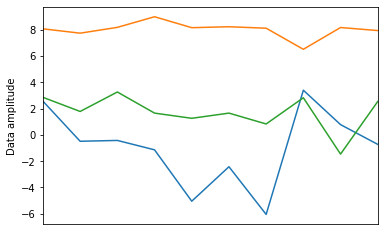

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(target_data.T)
ax.set(
    ylabel="Data amplitude",
    xticks=[],
    xlim=(0, 9));

As well as knowing the likelihood for this problem, we also know what sufficient statistics describe the mean and variance of the data - they are the mean and the variance
$$\frac{1}{n_{\bf d}}\sum_i^{n_{\bf d}}d_i = \mu\textrm{  and  }\frac{1}{n_{\bf d}-1}\sum_i^{n_{\bf d}}(d_i-\mu)^2=\Sigma$$
This means we can make an exact compression function

In [7]:
def compressor(simulation):
    return np.stack([
     np.mean(simulation, axis=-1),
     np.var(simulation, axis=-1)], 
    axis=-1)

In [8]:
print(f"Mean and variance of observed data = {compressor(target_data)}")

Mean and variance of observed data = [[-0.95406663  7.982314  ]
 [ 8.011085    0.34187225]
 [ 1.7216978   1.6701807 ]]


We might want to know how likely it is that any particular parameters of the Gaussian model are given that we have observed this data. This is given by the posterior distribution
$$\mathcal{P}(\mu,\Sigma|{\bf d})\propto\mathcal{L}({\bf d}|\mu,\Sigma)p(\mu, \Sigma)$$

For example, let's say we want to know how likely it is that this data came from a model with some fiducial parameters $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$.

In [9]:
θ_fid = np.array([0., 1.])

We can evaluate the analytic posterior using:

In [10]:
likelihood(θ_fid).log_prob(target_data) + prior.log_prob(θ_fid)

DeviceArray([ -58.95049 , -337.08444 ,  -37.659824], dtype=float32)

And plot the contours like:

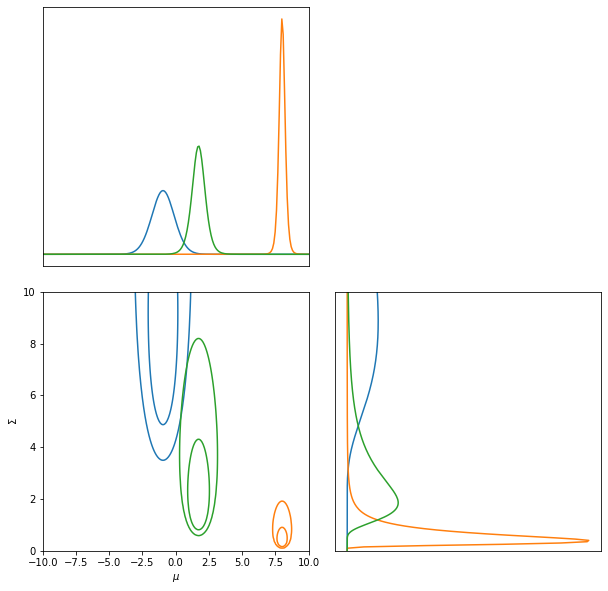

In [11]:
LFI = imnn.lfi.LikelihoodFreeInference(prior=prior, gridsize=200)
LFI.n_targets = 3
raveled_ranges = np.stack(
    [np.repeat(LFI.ranges[0], LFI.ranges[1].shape[0]),
     np.tile(LFI.ranges[1], LFI.ranges[0].shape[0])], 
    -1)
posterior = np.exp(
    jax.vmap(likelihood(raveled_ranges).log_prob)(target_data) 
    + prior.log_prob(raveled_ranges)).reshape((3, LFI.gridsize[0], LFI.gridsize[1]))
posterior = np.where(
    np.isnan(posterior),
    np.zeros_like(posterior),
    posterior)
LFI.marginals = LFI.put_marginals(posterior)
LFI.marginal_plot(axis_labels=["$\mu$", "$\Sigma$"]);

In the `lfi` submodule there are a handful of functions which allow us to do likelihood-free inference (LFI). The first order approximation is the Gaussian approximation to the likelihood.

We can calculate the Fisher information by taking the negative second derivative of the likelihood taking the expectation by inserting the relations for the sufficient statistics and examining at the fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$

In [12]:
def F(Σ, n_d):
    return - np.array([[- n_d / Σ, 0.], [0., - n_d / (2. * Σ**2.)]])

In [13]:
parameter_estimates = compressor(target_data)
GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=parameter_estimates, 
    invF=np.stack([np.linalg.inv(F(pe[1], 10.)) for pe in parameter_estimates], 0),
    prior=prior,
    gridsize=200)

The inverse Fisher information describes the Cramer-Rao bound, i.e. the minimum variance of a Gaussian approximation of the likelihood about the fiducial parameter values. We can therefore use the Fisher information to make an approximation to posterior.

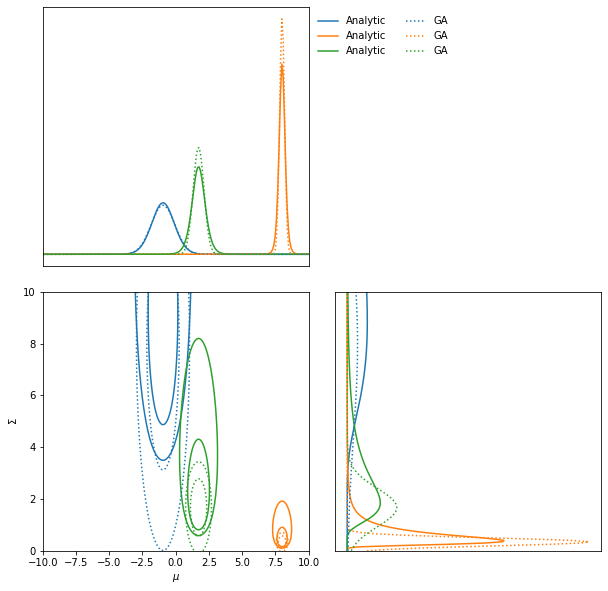

In [14]:
ax = LFI.marginal_plot(axis_labels=["$\mu$", "$\Sigma$"], label="Analytic")
GA.marginal_plot(ax=ax, linestyle="dotted", label="GA");

## Approximate Bayesian computation
We can also do approximate Bayesian computation using the mean and variance as sufficient statistics describing the data. The ABC draws parameter values from the prior and makes simulations at these points. These simulations are then summarised, i.e. we find the mean and variance of the simulations in this case, and then the distance between these estimates and the estimate of the target data can be calculated. Estimates within some small ϵ-ball around the target estimate are approximately samples from the posterior. Note that the larger the value of ϵ, the worse the approximation to the posterior. 

In [15]:
ABC = imnn.lfi.ApproximateBayesianComputation(
    target_data=target_data, 
    prior=prior, 
    simulator=lambda key, θ: likelihood(θ).sample(seed=key),
    compressor=compressor,
    F=np.stack([F(pe[1], 10.) for pe in parameter_estimates], 0))

In [16]:
rng, key = jax.random.split(rng)
ABC(rng=key, n_samples=int(1e5), 
    min_accepted=1000, max_iterations=100, 
    ϵ=1, smoothing=1);

[40968  1008 10615] accepted in last  16 iterations  (1600000 simulations done).


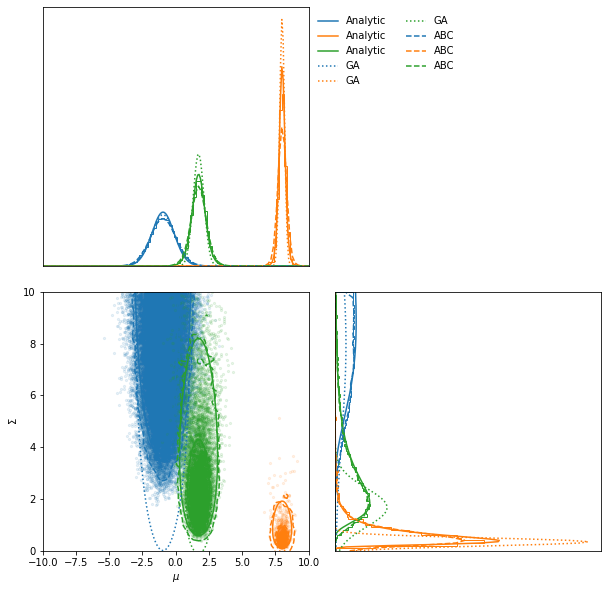

In [17]:
ax = ABC.scatter_plot(
    axis_labels=["$\mu$", "$\Sigma$"],
    alpha=0.1)
LFI.marginal_plot(
    ax=ax, 
    label="Analytic")
GA.marginal_plot(
    ax=ax, 
    linestyle="dotted", label="GA")
ABC.marginal_plot(
    ax=ax,
    linestyle="dashed", label="ABC");

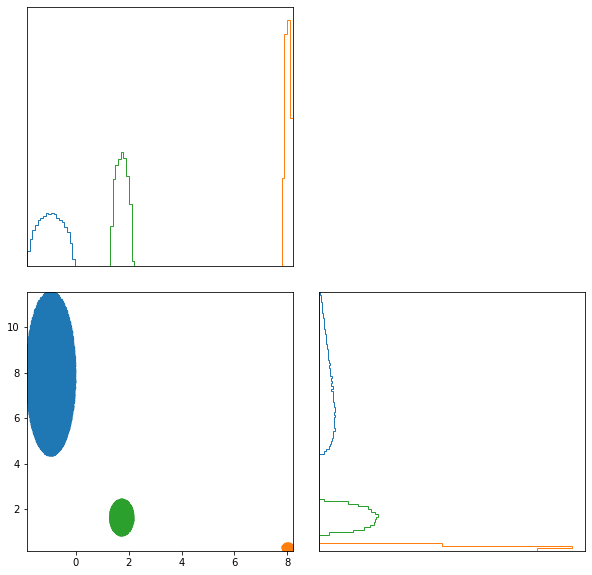

In [18]:
ABC.scatter_summaries();

## Population Monte Carlo (currently seems to have a bug)

Whilst we can obtain approximate posteriors using ABC, the rejection rate is very high because we sample always from the prior. Population Monte Carlo (PMC) uses statistics of the population of samples to propose new parameter values, so each new simulation is more likely to be accepted. This prevents us needing to define an ϵ parameter to define the acceptance distance. Instead we start with a population from the prior and iteratively move samples inwards. Once it becomes difficult to move the population any more, i.e. the number of attempts to accept a parameter becomes very large, then the distribution is seen to be a stable approximation to the posterior.

The whole module works very similarly to `ApproximateBayesianComputation` with a few changes in arguments.

In [19]:
PMC = imnn.lfi.PopulationMonteCarlo(
    target_data=target_data, 
    prior=prior,
    simulator=lambda key, θ: likelihood(θ).sample(seed=key),
    compressor=compressor,
    F=np.stack([F(pe[1], 10) for pe in parameter_estimates], 0))

In [21]:
rng, key = jax.random.split(rng)
PMC(rng=key, n_points=1000, n_initial_points=10000,
    percentile=None, acceptance_ratio=0.01, smoothing=1);

Acceptance reached [0. 0. 0.] in [1 1 1] iterations with a total of [1 1 1] draws


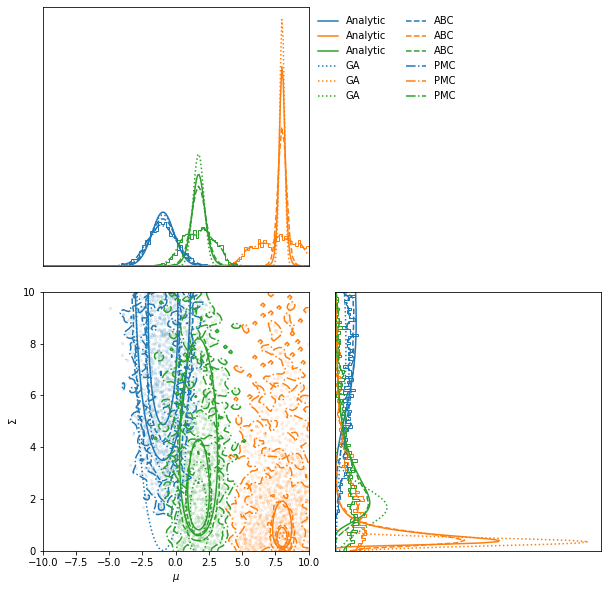

In [24]:
ax = PMC.scatter_plot(
    axis_labels=["$\mu$", "$\Sigma$"],
    alpha=0.1)
LFI.marginal_plot(
    ax=ax, 
    label="Analytic")
GA.marginal_plot(
    ax=ax, 
    linestyle="dotted", label="GA")
ABC.marginal_plot(
    ax=ax,
    linestyle="dashed", label="ABC")
PMC.marginal_plot(
    ax=ax,
    linestyle="dashdot", label="PMC");

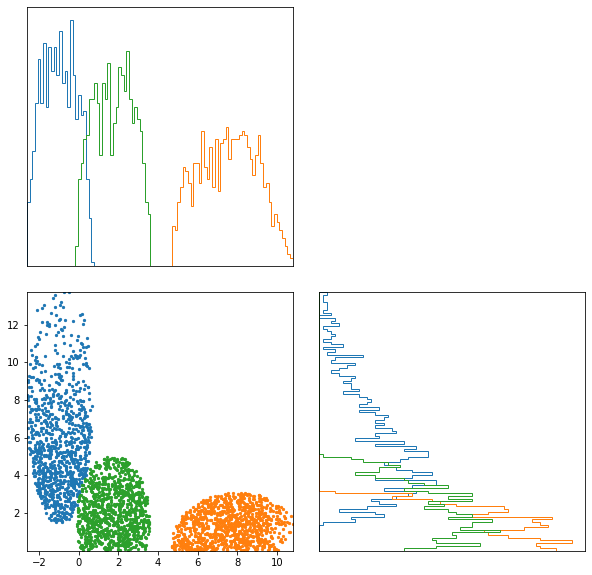

In [23]:
PMC.scatter_summaries();